# `HumanPreferencesEnvWrapper` 解读

`HumanPreferencesEnvWrapper` 包装器（Wrapper），它从内部环境（`env`）的 `.step()` 函数返回的观察结果中收集片段，并将这些段发送到偏好接口（PrefInterface），该接口查询人类或合成奖励预言机以获取偏好。

- 主要功能：
1. **收集段**：从内部环境的 `.step()` 函数返回的观察结果中收集段。
2. **发送段到偏好接口**：将这些段发送到偏好接口，该接口会查询人类或合成奖励预言机以获取偏好。
3. **管理奖励预测网络的训练和使用**：
   - 创建奖励预测网络，并使用存储在偏好数据库（`PrefDB`）中的偏好作为训练示例。
   - 当达到最小训练步数时，加载训练好的奖励预测网络，并将其作为返回的奖励，而不是底层环境奖励。

- 参数说明：
- **env**: 底层环境。
- **reward_predictor_network**: 一个可调用对象，将输入观测映射到奖励标量。
- **train_reward**: 布尔值，指定是否应该为环境训练奖励预测器。
- **collect_prefs**: 布尔值，指定是否应该在偏好数据库（PrefDB）中收集偏好。
- **segment_length**: 段的长度，即多少个观测结果构成一个段。
- **mp_context**: 字符串，指定此环境的多处理上下文。
- **prefs_dir**: 字符串路径，指定现有偏好数据库的位置（如果存在）。
- **log_dir**: 字符串路径，指定日志和运行工件保存的位置。
- **max_prefs_in_db**: 存储在训练和验证偏好数据库中的最大偏好数量。
- **obs_transform_func**: 可选的转换函数，用于将内部环境返回的观测结果转换为应连接形成段的观测结果。
- **n_initial_training_steps**: 开始使用训练好的奖励模型作为返回环境奖励之前要执行的训练步骤数。
- **n_initial_prefs**: 开始训练奖励预测器之前要收集的偏好数量。
- **pretrained_reward_predictor_dir**: 字符串路径，指定预训练奖励预测器的保存位置（如果存在）。
- **reward_predictor_refresh_interval**: 奖励预测器训练步骤的间隔，在此间隔内更新环境中使用的奖励预测器。
- **validation_interval**: 奖励预测器训练步骤的间隔，在此间隔内进行验证。
- **reward_database_refresh_interval**: 奖励预测器训练步骤的间隔，在此间隔内刷新用于训练/验证的偏好数据库。
- **reward_predictor_ckpt_interval**: 奖励训练步骤的间隔，在此间隔内自动检查点奖励预测模型。
- **synthetic_prefs**: 如果为True，使用环境的奖励函数计算偏好；如果为False，使用GUI界面查询人类的偏好。
- **max_pref_interface_segs**: 偏好接口可以存储和配对的最大段数。
- **zoom_ratio**: 图像显示给人类时的缩放比例（如果使用合成偏好则忽略）。
- **channels**: 显示给人类的图像的通道数（不能从观测空间形状推断，因为常见用法涉及沿通道维度堆叠帧的FrameStack包装器）。
- **env_wrapper_log_level**: 包装器整体的日志级别。
- **reward_predictor_log_level**: 奖励预测器训练函数的日志级别。
- **pref_interface_log_level**: 偏好接口使用的日志级别。

这个包装器的主要目的是通过与人类或合成奖励预言机交互来学习偏好，并使用这些偏好来训练一个奖励预测网络。一旦训练完成，它会使用这个网络来生成奖励，从而替代底层环境的原始奖励。

In [1]:
import set_env
import logging
import sys
from pathlib import Path
from d2py.utils.log_config import config_logging
root_dir = Path(".").resolve()
sys.path.extend([str(root_dir.parents[2]/"tests/gym-multigrid")])

logger_dir = root_dir/".temp"
logger_dir.mkdir(parents=True, exist_ok=True)
temp_dir = root_dir/"images"
temp_dir.mkdir(parents=True, exist_ok=True)

logger_name = "drlhp"
logger = logging.getLogger(logger_name)
config_logging(f'{logger_dir}/{logger_name}.log', logger_name, maxBytes=50000, backupCount=2)

In [2]:
from pathlib import Path
import imageio
from gym_multigrid.envs.collect_game import CollectGameEnv
from drlhp.env import HumanPreferencesEnvWrapper
from drlhp.model import net_cnn

kwargs={
    "size": 15,
    "num_balls": [5,],
    "agents_index": [1, 2, 3],  # green, purple
    "balls_index": [0,],  # red, orange, yellow
    "balls_reward": [1,],
    "respawn": False,
}
origin_env = CollectGameEnv(**kwargs)

In [3]:
hp_env = HumanPreferencesEnvWrapper(
    origin_env, net_cnn,
    segment_length=1,
    mp_context='spawn',
    n_initial_training_steps=50,
    n_initial_prefs=40,
    train_reward=True,
    collect_prefs=True,
    synthetic_prefs=True,
    pref_interface_log_level=logging.DEBUG,
    reward_predictor_log_level=logging.DEBUG,
    env_wrapper_log_level=logging.DEBUG,
    prefs_dir=None,
)
frames = [hp_env.render()]
obs, info = hp_env.reset()
while 1:
    actions = [hp_env.env.action_space.sample() for _ in hp_env.env.agents]
    obs, reward, terminated, truncated, info = hp_env.step(actions)
    frames.append(hp_env.render())
    if terminated or truncated:
        logger.info(f"episode ended after {hp_env.env.step_count} steps")
        logger.info(f"agents collected {hp_env.env.collected_balls} objects")
        break

INFO|2024-10-30 16:54:09,667|drlhp| >>> episode ended after 100 steps
INFO|2024-10-30 16:54:09,668|drlhp| >>> agents collected 4 objects


RewardPredictorEnsemble created


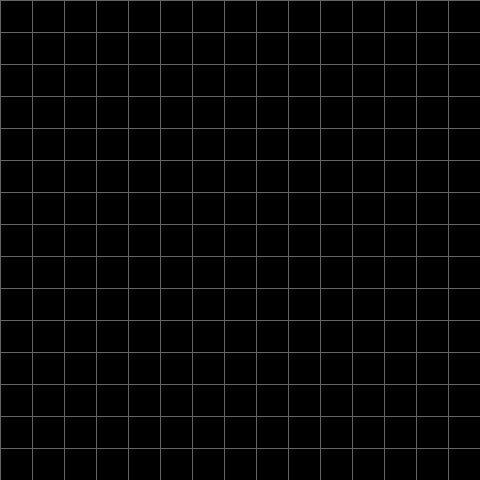

DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start training
DEBUG:_train_reward_predictor:Reward dbs of length (0, 0), waiting for minimum length (40, 1) to start t

In [4]:
from IPython import display
temp_dir = Path(temp_dir)
(temp_dir/"animations").mkdir(parents=True, exist_ok=True)
imageio.mimsave(temp_dir/f"animations/multigrid-collect.gif", frames, duration=0.5)
display.Image(temp_dir/f"animations/multigrid-collect.gif")